## Figure 1 - SOCS analysis of time-series Stereo-seq in developing mouse lung
This notebook shows how the panels of Figure 1 in our manuscript (which show the results of using SOCS to estimate differentiation trajectories in mouse lung organogenesis) were generated.

First, we load in package dependencies. These can be installed using the .yaml file in this folder.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import anndata as ad
import scipy as sp
import scanpy as sc
import squidpy as sq
import sklearn
import copy
import pickle
import json
import socs
from socs.utils import row_normalize
from socs.analysis import map_vector_sampled,hillNumber_1,vec2vec
import scipy.spatial as scisp
import seaborn as sns

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-02-17 22:18:30.893362: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 22:18:30.922641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 22:18:30.957629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been regist

We'll load in the processed count tables for the mouse lung at day E14.5 ($t_1$) and day E15.5 ($t_2$). These are saved as AnnData objects.

In [3]:
adata_1 = sc.read_h5ad('example_data/lung_14_2_processed.h5ad')
adata_2 = sc.read_h5ad('example_data/lung_15_4_processed.h5ad')

In [4]:
adata_1.obs['time'] = 0
adata_2.obs['time'] = 1

Each anndata object contains spatial locations and normalized gene expression profiles, along with cell type annotations, and labels for spatially contiguous structures stored in adata.obs, along with dimensionally-reduced representations (PCA and UMAP) stored in adata.obsm

In [4]:
adata_1

AnnData object with n_obs × n_vars = 1749 × 28766
    obs: 'clst_4', 'leiden', 'struct', 'struct_bool_c', 'struct_c', 'leiden_ep', 'leiden_plus'
    uns: 'leiden', 'leiden_plus_colors', 'log1p', 'neighbors', 'pca', 'struct_bool_c_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_sq'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Visualize spatial distribution of cell types

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


(-167.19999999999996, -118.79999999999997, -354.65, -472.35)

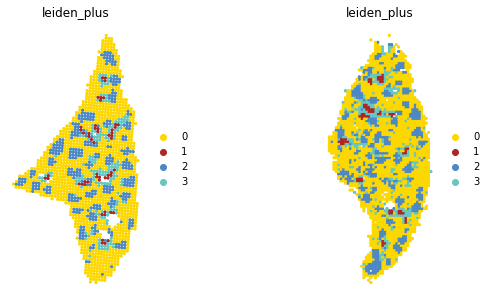

In [4]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='leiden_plus',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[0],
    size=15
)
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color='leiden_plus',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[1],
    size=15
)
axs[0].axis('off')
axs[1].axis('off')

## Visualize the distribution of spatially coherent airway structures (Fig. 1b)

(-167.19999999999996, -118.79999999999997, -354.65, -472.35)

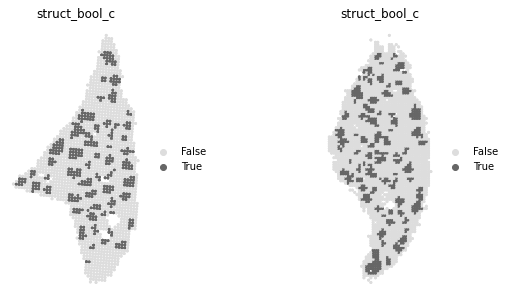

In [5]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='struct_bool_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[0],
    size=15
)
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color='struct_bool_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[1],
    size=15
)
axs[0].axis('off')
axs[1].axis('off')

(-167.19999999999996, -118.79999999999997, -354.65, -472.35)

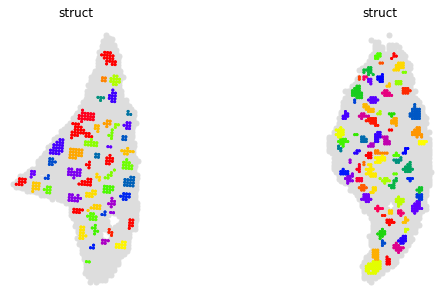

In [6]:
_,axs = plt.subplots(1,2,figsize=[10,5])
axs[0].scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=25,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_1[adata_1.obs['struct']!=0,:],
    shape=None,
    color='struct',
    library_id='spatial',
    spatial_key='spatial_sq',
    cmap='prism',
    ax=axs[0],
    size=15,
    colorbar=False,
)
axs[1].scatter(adata_2.obsm['spatial_sq'][:,0],adata_2.obsm['spatial_sq'][:,1],s=25,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_2[adata_2.obs['struct']!=0,:],
    shape=None,
    color='struct',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[1],
    cmap='prism',
    size=15,
    colorbar=False,
)
axs[0].axis('off')
axs[1].axis('off')

## Perform trajectory inference with SOCS
The next cells walk through the process of running SOCS on our mouse lung organogenesis data.

First, we put together the anndata objects, labeled by time-point, and perform principle component analysis on the combined object. We also define variables for the structure labels ($\beta$) and spatial coordinates, for future use.

In [6]:
adata_concat= ad.concat([adata_1,adata_2])
sc.pp.pca(adata_concat, random_state= 0,n_comps=30)
beta_1 = adata_1.obs['struct']
beta_2 = adata_2.obs['struct']
xy_1 = adata_1.obsm['spatial']
xy_2 = adata_2.obsm['spatial']

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12030. The TBB threading layer is disabled.
  warnings.warn(problem)


We then define SOCS problem using the class SOCSModel, using a set of parameters $\alpha$, $\epsilon$, $\rho_1$, and $\rho_2$, as described in __Methods__

In [7]:
alpha = 0.1
eps = 1e-3
rho1 = 5000.0
rho2 = 5000.0

socs_model = socs.ot.SOCSModel(adata_concat,'time',expr_key='X_pca',struct_key='struct',alpha=alpha,eps=eps,rho=rho1,rho2=rho2,struct_excl=[0])

We then use this SOCS problem to learn a transport map. We also compute a row-normalized version.

In [8]:
T_socs = socs_model.infer_map(0,1)
T_socs_n = row_normalize(T_socs)

## Analysis of trajectory inference transport map
We'll load in previously-computed transport maps generated by Waddington-OT (W-OT) and Moscot, for comparison to the map generated by SOCS

In [9]:
T_wot = np.load('example_data/lung_14_15_wot.npy')
T_wot_n = row_normalize(T_wot)
T_moscot = np.load('example_data/lung_14_15_e0001_moscot_0.2.npy')
T_moscot_n = row_normalize(T_moscot)

We can visualize the distribution of the inferred descendants at E15.5 of the spots comprising a particular airway at E14.5, comparing the mappings from SOCS, W-OT, and Moscot, reproducing Fig. 1c.

(-167.19999999999996, -118.79999999999997, 354.65, 472.35)

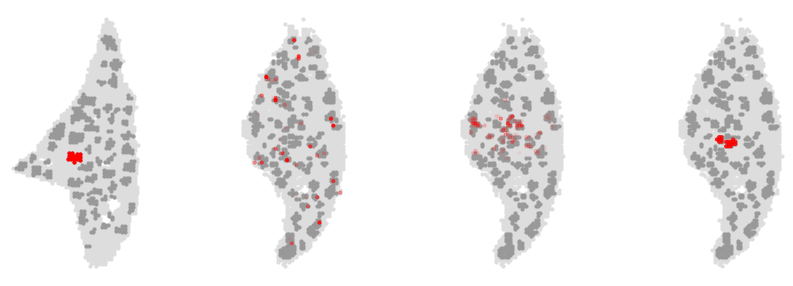

In [10]:
airway_number = 25
inds_all_airways_1 = np.where(beta_1!=0)[0]
inds_all_airways_2 = np.where(beta_2!=0)[0]
inds_airway = np.where(beta_1==airway_number)[0]
_,axs = plt.subplots(1,4,figsize=[15,5])
axs[0].scatter(xy_1[:,0],xy_1[:,1],s=10,c='#DDDDDD')
axs[0].scatter(xy_1[inds_all_airways_1,0],xy_1[inds_all_airways_1,1],s=10,c='#999999')
axs[0].scatter(xy_1[inds_airway,0],xy_1[inds_airway,1],s=10,c='red')
axs[0].set_aspect(1)
axs[0].axis('off')
axs[1].scatter(xy_2[:,0],xy_2[:,1],s=10,c='#DDDDDD')
axs[1].scatter(xy_2[inds_all_airways_2,0],xy_2[inds_all_airways_2,1],s=10,c='#999999')
axs[1].scatter(xy_2[:,0],xy_2[:,1],s=10,c='red',alpha = np.sum(T_wot_n[inds_airway,:],axis=0))
axs[1].set_aspect(1)
axs[1].axis('off')
axs[2].scatter(xy_2[:,0],xy_2[:,1],s=10,c='#DDDDDD')
axs[2].scatter(xy_2[inds_all_airways_2,0],xy_2[inds_all_airways_2,1],s=10,c='#999999')
axs[2].scatter(xy_2[:,0],xy_2[:,1],s=10,c='red',alpha = np.sum(T_moscot_n[inds_airway,:],axis=0))
axs[2].set_aspect(1)
axs[2].axis('off')
axs[3].scatter(xy_2[:,0],xy_2[:,1],s=10,c='#DDDDDD')
axs[3].scatter(xy_2[inds_all_airways_2,0],xy_2[inds_all_airways_2,1],s=10,c='#999999')
axs[3].scatter(xy_2[:,0],xy_2[:,1],s=10,c='red',alpha = np.sum(T_socs_n[inds_airway,:],axis=0))
axs[3].set_aspect(1)
axs[3].axis('off')

Here, we compute the proportion of the spots belonging to each airway at E14.5 which map to each of the airways at E15.5, using the maps generated by SOCS, W-OT, and Moscot.

In [11]:
struct2struct = vec2vec(beta_1,beta_2,T_socs)
struct2struct_wot = vec2vec(beta_1,beta_2,T_wot)
struct2struct_moscot = vec2vec(beta_1,beta_2,T_moscot)

/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vec_mapped.append(vec[rx_bin])
/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ind_x = v1_vals.index(v1[x])


From these generated structures, we compute the Hill number of each column, which can be interpreted as the effective number of "ancestor" airways at E14.5 corresponding to each airway at E15.5.   

In [12]:
hn_s = hillNumber_1(struct2struct[1:,1:].T)
hn_s_wot = hillNumber_1(struct2struct_wot[1:,1:].T)
hn_s_moscot = hillNumber_1(struct2struct_moscot[1:,1:].T)
print(np.nanmedian(hn_s))
print(np.nanmedian(hn_s_wot))
print(np.nanmedian(hn_s_moscot))

1.0
4.0
2.82842712474619


We can visualize the distribution of the effective number of ancestor airways in a strip plot, comparing the result from the mappings produced by SOCS, W-OT, and Moscot, reproducing Fig. 1d

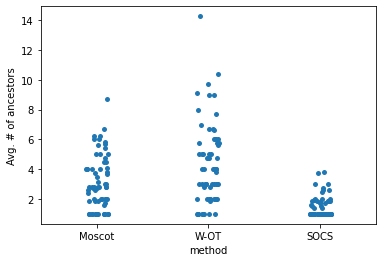

In [13]:
df_m = pd.DataFrame(hn_s_moscot,columns=['Avg. # of ancestors'])
df_m['method'] = 'Moscot'
df_w = pd.DataFrame(hn_s_wot,columns=['Avg. # of ancestors'])
df_w['method'] = 'W-OT'
df_s = pd.DataFrame(hn_s,columns=['Avg. # of ancestors'])
df_s['method'] = 'SOCS'
df_all = pd.concat([df_m,df_w,df_s],axis=0,ignore_index=True)
sns.stripplot(data=df_all,x='method',y='Avg. # of ancestors')
plt.savefig('example_data/output/figs/n_ancestors_stripplot.svg')

Here, we want to confirm that the SOCS' advantage in maintaining structural coherence does not result in a loss of geometric consistency. We first compute the positions at E15.5 of the inferred descendants of each spot at E14.5.  

In [14]:
x_mapped_socs = map_vector_sampled(xy_2[:,0],T_socs)
y_mapped_socs = map_vector_sampled(xy_2[:,1],T_socs)
x_mapped_wot = map_vector_sampled(xy_2[:,0],T_wot)
y_mapped_wot = map_vector_sampled(xy_2[:,1],T_wot)
x_mapped_moscot = map_vector_sampled(xy_2[:,0],T_moscot)
y_mapped_moscot = map_vector_sampled(xy_2[:,1],T_moscot)

From these mapped positions, we compute the pairwise distances between the descendants of each spot:

In [15]:
xy_mapped_socs = np.stack([x_mapped_socs,y_mapped_socs],axis=1)
D_1_mapped_socs = np.ascontiguousarray(sklearn.metrics.pairwise.pairwise_distances(xy_mapped_socs,Y=xy_mapped_socs,metric='euclidean',n_jobs=1))
xy_mapped_wot = np.stack([x_mapped_wot,y_mapped_wot],axis=1)
D_1_mapped_wot = np.ascontiguousarray(sklearn.metrics.pairwise.pairwise_distances(xy_mapped_wot,Y=xy_mapped_wot,metric='euclidean',n_jobs=1))
xy_mapped_moscot = np.stack([x_mapped_moscot,y_mapped_moscot],axis=1)
D_1_mapped_moscot = np.ascontiguousarray(sklearn.metrics.pairwise.pairwise_distances(xy_mapped_moscot,Y=xy_mapped_moscot,metric='euclidean',n_jobs=1))

The positions in the MOSTA data are stored in nonstandard units, so we convert these distances to millimeters.

In [16]:
D_1,_,_ = socs_model.compute_distance_matrices(0,1)
px_per_mm = 38
D_1_mm = D_1/px_per_mm
D_1_mapped_socs_mm = D_1_mapped_socs/px_per_mm
D_1_mapped_wot_mm = D_1_mapped_wot/px_per_mm
D_1_mapped_moscot_mm = D_1_mapped_moscot/px_per_mm

To evaluate the geometric consistency of each map, we compute the correlation between the pairwise distances between spots at E14.5, and the pairwise distances between their descendant spots at E15.5.
We can also visualize this with a two-dimensional histogram of these pairwise distances, reproducing Fig. 1e.

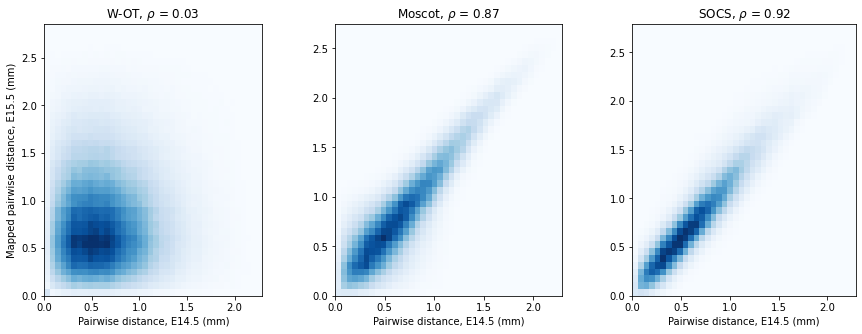

In [17]:
pairwise_corr_socs = np.corrcoef(D_1_mm.flatten(),D_1_mapped_socs_mm.flatten())[0,1]
pairwise_corr_wot = np.corrcoef(D_1_mm.flatten(),D_1_mapped_wot_mm.flatten())[0,1]
pairwise_corr_moscot = np.corrcoef(D_1_mm.flatten(),D_1_mapped_moscot_mm.flatten())[0,1]
_,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].hist2d(D_1_mm.flatten(),D_1_mapped_wot_mm.flatten(),bins=40,cmap='Blues')
axs[0].set_aspect(1)
axs[0].set_xlabel('Pairwise distance, E14.5 (mm)')
axs[0].set_ylabel('Mapped pairwise distance, E15.5 (mm)')
axs[0].set_title(r'W-OT, $\rho$ = {:.2f}'.format(pairwise_corr_wot))
axs[1].hist2d(D_1_mm.flatten(),D_1_mapped_moscot_mm.flatten(),bins=40,cmap='Blues')
axs[1].set_aspect(1)
axs[1].set_xlabel('Pairwise distance, E14.5 (mm)')
axs[1].set_title(r'Moscot, $\rho$ = {:.2f}'.format(pairwise_corr_moscot))
axs[2].hist2d(D_1_mm.flatten(),D_1_mapped_socs_mm.flatten(),bins=40,cmap='Blues')
axs[2].set_aspect(1)
axs[2].set_xlabel('Pairwise distance, E14.5 (mm)')
axs[2].set_title(r'SOCS, $\rho$ = {:.2f}'.format(pairwise_corr_socs))
plt.savefig('example_data/output/figs/pw_corrs.svg')

Finally, we compute the proportion of spots at E14.5 belonging to each cell type which map to each cell type at E15.5. 

In [18]:
clsts_1 = adata_1.obs['leiden_plus']
clsts_2 = adata_2.obs['leiden_plus']
type2type_socs = vec2vec(clsts_1,clsts_2,T_socs)
type2type_socs_n = row_normalize(type2type_socs)
type2type_wot = vec2vec(clsts_1,clsts_2,T_wot)
type2type_wot_n = row_normalize(type2type_wot)
type2type_moscot = vec2vec(clsts_1,clsts_2,T_moscot)
type2type_moscot_n = row_normalize(type2type_moscot)


/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vec_mapped.append(vec[rx_bin])
/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ind_x = v1_vals.index(v1[x])


We can visualize this mapping between cell types with a series of bar plots comparing the mappings produced by SOCS, W-OT, and Moscot, reproducing figure 1f.

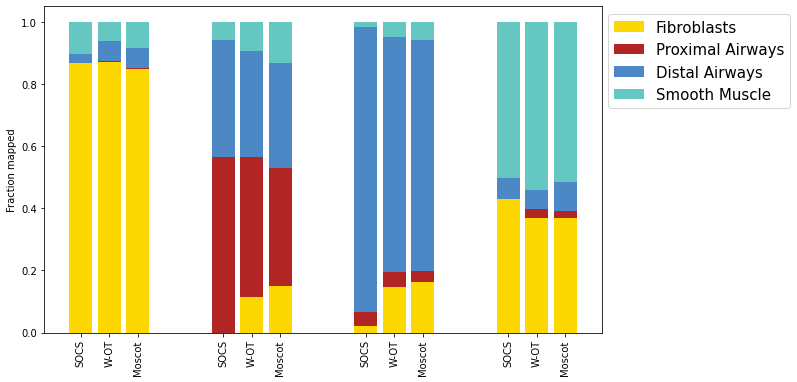

In [19]:
plt.figure(figsize=[10,6])
colors_1 = adata_1.uns['leiden_plus_colors']
cVal = 0
for y in range(4):
    yx = y*5
    for x in range(4):
        plt.bar(yx-1,type2type_socs_n[y,x],bottom=np.sum(type2type_socs_n[y,0:x]),color=colors_1[x])
        plt.bar(yx,type2type_wot_n[y,x],bottom=np.sum(type2type_wot_n[y,0:x]),color=colors_1[x],label='_nolegend_')
        plt.bar(yx+1,type2type_moscot_n[y,x],bottom=np.sum(type2type_moscot_n[y,0:x]),color=colors_1[x],label='_nolegend_')
_ = plt.xticks([-1,0,1,4,5,6,9,10,11,14,15,16],labels=['SOCS','W-OT','Moscot','SOCS','W-OT','Moscot','SOCS','W-OT','Moscot','SOCS','W-OT','Moscot'],rotation=90)
plt.ylabel('Fraction mapped')
plt.legend(['Fibroblasts','Proximal Airways','Distal Airways','Smooth Muscle'],loc='upper right',bbox_to_anchor=(1.35,1.0),fontsize=15)
plt.savefig('example_data/output/figs/cell_type_mapping.svg')